## Задача: 
    нужно предсказать, сможет ли пользователь успешно закончить онлайн курс Анализ данных в R.

Мы будем считать, что пользователь успешно закончил курс, если он правильно решил больше 40 практических заданий.

В данных:

submission_data_test.csv
events_data_test.csv
хранится информация о решениях и действиях для 6184 студентов за первые два дня прохождения курса. Это 6184 студентов, которые проходили курс в период с мая 2018 по январь 2019. Подробное описание переменных смотри в этом шаге.  

Используя данные о первых двух днях активности на курсе вам нужно предсказать, наберет ли пользователь более 40 баллов на курсе или нет.

В этих данных, вам доступны только первые дня активности студентов для того, чтобы сделать предсказание. На самом деле, используя эти данные, вы уже можете сделать прогноз. Например, если пользователь за первые два дня набрал 40 баллов, скорее всего он наберет более 40 баллов в дальнейшем. Чтобы подкрепить такие гипотезы, вы можете использовать данные, на которые мы исследовали в первых двух модулях курса, где для всех пользователей представлены все данные об их активности на курсе. 

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV 

In [2]:
submission_data_test = pd.read_csv('https://stepik.org/media/attachments/course/4852/submission_data_test.csv') 
submission_data_test.head() 

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370


In [3]:
# Посмотрим, есть ли пустые значения
submission_data_test.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42261 entries, 0 to 42260
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   step_id            42261 non-null  int64 
 1   timestamp          42261 non-null  int64 
 2   submission_status  42261 non-null  object
 3   user_id            42261 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.3+ MB


In [4]:
events_data_test = pd.read_csv('https://stepik.org/media/attachments/course/4852/events_data_test.csv') 
events_data_test.head() 

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417


In [19]:
# Посмотрим на варианты действий в таблице
events_data_test.action.unique() 

array(['viewed', 'discovered', 'passed', 'started_attempt'], dtype=object)

In [5]:
# Посмотрим, есть ли пустые значения
events_data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274768 entries, 0 to 274767
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   step_id    274768 non-null  int64 
 1   timestamp  274768 non-null  int64 
 2   action     274768 non-null  object
 3   user_id    274768 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 8.4+ MB


In [6]:
# Добавим колонку с датой в обе тадлицы
events_data_test['date'] = pd.to_datetime(events_data_test.timestamp, unit='s') 
submission_data_test['date'] = pd.to_datetime(submission_data_test.timestamp, unit='s') 

<AxesSubplot:>

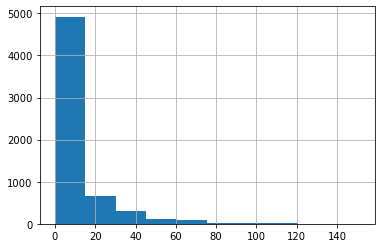

In [20]:
events_data_test.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count',
                        fill_value=0).reset_index().passed.hist() 

In [8]:
# Сделаем сводную таблицу действий пользователей
users_events_data = events_data_test.pivot_table(index='user_id', 
                                                 columns='action', 
                                                 values='step_id', 
                                                 aggfunc='count',
                                                 fill_value=0).reset_index() 

In [23]:
# Посмотрим какой процент пользователей решил 40 и более заданий
round(users_events_data[users_events_data['passed'] >= 40].user_id.nunique() * 100 / users_events_data.user_id.nunique(), 2) 

6.45

In [13]:
users_events_data.head() 

action,user_id,discovered,passed,started_attempt,viewed
0,4,1,1,0,1
1,6,1,1,0,1
2,10,2,2,0,6
3,12,11,9,4,14
4,13,70,70,35,105


In [11]:
# Сделаем сводную таблицу попыток ответов пользователей
users_scores = submission_data_test.pivot_table(index='user_id', 
                                                columns='submission_status', 
                                                values='step_id', 
                                                aggfunc='count', 
                                                fill_value=0).reset_index() 

In [12]:
users_scores.head()

submission_status,user_id,correct,wrong
0,12,1,0
1,13,29,36
2,15,10,30
3,21,24,103
4,35,7,35


<AxesSubplot:>

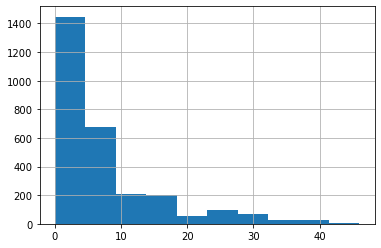

In [14]:
users_scores.correct.hist() 

In [24]:
users_data = events_data_test.groupby('user_id', as_index=False) \
        .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'}) 

In [25]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0) 

In [26]:
users_data.head() 

,user_id,last_timestamp,correct,wrong
0,4,1529331707,0.0,0.0
1,6,1546889407,0.0,0.0
2,10,1534593770,0.0,0.0
3,12,1537348641,1.0,0.0
4,13,1533162170,29.0,36.0


In [27]:
users_data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6184 entries, 0 to 6183
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         6184 non-null   int64  
 1   last_timestamp  6184 non-null   int64  
 2   correct         6184 non-null   float64
 3   wrong           6184 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 241.6 KB


In [28]:
from scipy import stats
chi2, p_value, dof, ev = stats.chi2_contingency(([20,15],[11,12],[7,9]))
print(f'''
Хи квадрат {chi2}
p - value {p_value}
Степеней свобод {dof}
Ожидаемые наблюдения
{ev}
''')


Хи квадрат 0.9544070774762996
p - value 0.6205162173513055
Степеней свобод 2
Ожидаемые наблюдения
[[17.97297297 17.02702703]
 [11.81081081 11.18918919]
 [ 8.21621622  7.78378378]]



In [29]:
submission_data_test.head() 

,step_id,timestamp,submission_status,user_id,date
0,31971,1526800961,wrong,24370,2018-05-20 07:22:41
1,31971,1526800976,wrong,24370,2018-05-20 07:22:56
2,31971,1526800993,wrong,24370,2018-05-20 07:23:13
3,31971,1526801054,correct,24370,2018-05-20 07:24:14
4,31972,1526800664,wrong,24370,2018-05-20 07:17:44


In [30]:
# Добавим колонку с датой
submission_data_test['day'] = submission_data_test.date.dt.date 

In [167]:
# Заведём датафрейм X, который будем наполнять свойствами user за первые три дня
X = submission_data_test.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns={'day':'days'}) 

In [168]:
X.head() 

,user_id,days
0,12,1
1,13,2
2,15,3
3,21,1
4,35,3


In [34]:
# Посчитаем сколько степов прошёл пользователь за первые три дня
steps_tried = submission_data_test.groupby('user_id').step_id.nunique().to_frame().reset_index().rename(columns={'step_id':'steps_tried'})

In [169]:
# Будем наращивать X 
X = X.merge(steps_tried, on='user_id', how='outer') 

In [170]:
# Добавим столбцы с количеством правильных и неправильных ответов
X = X.merge(submission_data_test.pivot_table(index='user_id',
                                             columns='submission_status', 
                                             values = 'step_id', 
                                             aggfunc = 'count', 
                                             fill_value=0).reset_index()) 

In [171]:
X.head() 

,user_id,days,steps_tried,correct,wrong
0,12,1,1,1,0
1,13,2,29,29,36
2,15,3,11,10,30
3,21,1,30,24,103
4,35,3,9,7,35


In [172]:
# Добавим колонку с долей правильных ответов
X['correct_ratio'] = X.correct / (X.correct + X.wrong) 

In [173]:
# Добавим столбцы с количеством действий
X = X.merge(events_data_test.pivot_table(index='user_id', 
                                          columns='action', 
                                          values='step_id', 
                                          aggfunc='count', 
                                          fill_value=0).reset_index()[['user_id', 'viewed']], how='outer') 

In [174]:
# Заменим пустые значения на 0
X = X.fillna(0) 

In [43]:
users_data = users_data.merge(users_events_data, how='outer') 
users_data.head() 

,user_id,last_timestamp,correct,wrong,discovered,passed,started_attempt,viewed
0,4,1529331707,0.0,0.0,1,1,0,1
1,6,1546889407,0.0,0.0,1,1,0,1
2,10,1534593770,0.0,0.0,2,2,0,6
3,12,1537348641,1.0,0.0,11,9,4,14
4,13,1533162170,29.0,36.0,70,70,35,105


In [44]:
# Добавим к тем кто решил больше 40 заданий 1, остальным 0
users_data['passed_course'] = users_data.passed > 40 

In [45]:
users_data.head() 

,user_id,last_timestamp,correct,wrong,discovered,passed,started_attempt,viewed,passed_course
0,4,1529331707,0.0,0.0,1,1,0,1,False
1,6,1546889407,0.0,0.0,1,1,0,1,False
2,10,1534593770,0.0,0.0,2,2,0,6,False
3,12,1537348641,1.0,0.0,11,9,4,14,False
4,13,1533162170,29.0,36.0,70,70,35,105,True


In [175]:
# Добавим к X колонку с пройденным курсом
X = X.merge(users_data[['user_id', 'passed_course']], how='outer') 

In [176]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course
0,12,1.0,1.0,1.0,0.0,1.000000,14,False
1,13,2.0,29.0,29.0,36.0,0.446154,105,True
2,15,3.0,11.0,10.0,30.0,0.250000,1,False
3,21,1.0,30.0,24.0,103.0,0.188976,98,True
4,35,3.0,9.0,7.0,35.0,0.166667,70,False


In [177]:
# Определим колонку для предсказания и заменим на 1 
y = X.passed_course.map(int) 
# Удалим эту колонку из X
X = X.drop(['passed_course'], axis=1) 
X = X.set_index(X.user_id) # используем user_id для индекса и удалим эту колонку
X = X.drop('user_id', axis=1) 

In [178]:
X.head() 

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
12,1.0,1.0,1.0,0.0,1.000000,14
13,2.0,29.0,29.0,36.0,0.446154,105
15,3.0,11.0,10.0,30.0,0.250000,1
21,1.0,30.0,24.0,103.0,0.188976,98
35,3.0,9.0,7.0,35.0,0.166667,70


In [179]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6184 entries, 12 to 26800
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   days           6184 non-null   float64
 1   steps_tried    6184 non-null   float64
 2   correct        6184 non-null   float64
 3   wrong          6184 non-null   float64
 4   correct_ratio  6184 non-null   float64
 5   viewed         6184 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 338.2 KB


In [180]:
# Посмотрим на точность предсказаний с параметрами ниже
clf_rf = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini', max_depth=None, max_features='auto',
                              max_leaf_nodes=None, min_impurity_decrease=0.0,
                              min_impurity_split=None, min_samples_leaf=10,
                              min_samples_split=10, min_weight_fraction_leaf=0.0,
                              n_estimators=100, n_jobs=2, oob_score=False,
                              random_state=None, verbose=0, warm_start=False) 
clf_rf.fit(X, y) 
display(clf_rf.score(X, y)) 

0.9817270375161707

Мы будем заниматься подбором следующих гиперпараметров:

+ n_estimators — число «деревьев» в «случайном лесу».  
+ max_features — число признаков для выбора расщепления.  
+ max_depth — максимальная глубина деревьев.  
+ min_samples_split — минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться.  
+ min_samples_leaf — минимальное число объектов в листьях.  
+ bootstrap — использование для построения деревьев подвыборки с возвращением.  

In [181]:
from sklearn.model_selection import RandomizedSearchCV 

rfc = RandomForestClassifier() 
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X, y)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.7min finished


{'n_estimators': 560,
 'min_samples_split': 50,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 7,
 'bootstrap': False}

In [58]:
# Сохраним сведения о наборе параметров, позволяющем создать самую лучшую модель
params = {'n_estimators': 230,
          'min_samples_split': 18,
          'min_samples_leaf': 39,
          'max_features': 'log2',
          'max_depth': 2,
          'bootstrap': True} 

Для того чтобы выяснить то, в каком диапазоне значений стоит продолжать поиск, мы легко можем получить датафрейм, содержащий результаты работы алгоритма RandomizedSearchCV.

In [182]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,560,50,2,sqrt,7,False,0.985609,1
1,560,23,2,sqrt,15,False,0.985448,2
2,230,28,7,log2,13,True,0.985448,3
3,10,50,18,sqrt,6,False,0.985286,4
4,340,23,2,sqrt,14,False,0.985286,5
5,670,12,2,sqrt,13,False,0.985286,6
6,1000,12,7,sqrt,10,True,0.985286,7
7,1000,44,2,sqrt,9,True,0.985286,8
8,230,39,2,sqrt,3,True,0.985124,9
9,450,18,7,log2,7,True,0.985124,10


Теперь создадим столбчатые графики, на которых, по оси Х, расположены значения гиперпараметров, а по оси Y — средние значения, показываемые моделями. Это позволит понять то, какие значения гиперпараметров, в среднем, лучше всего себя показывают.

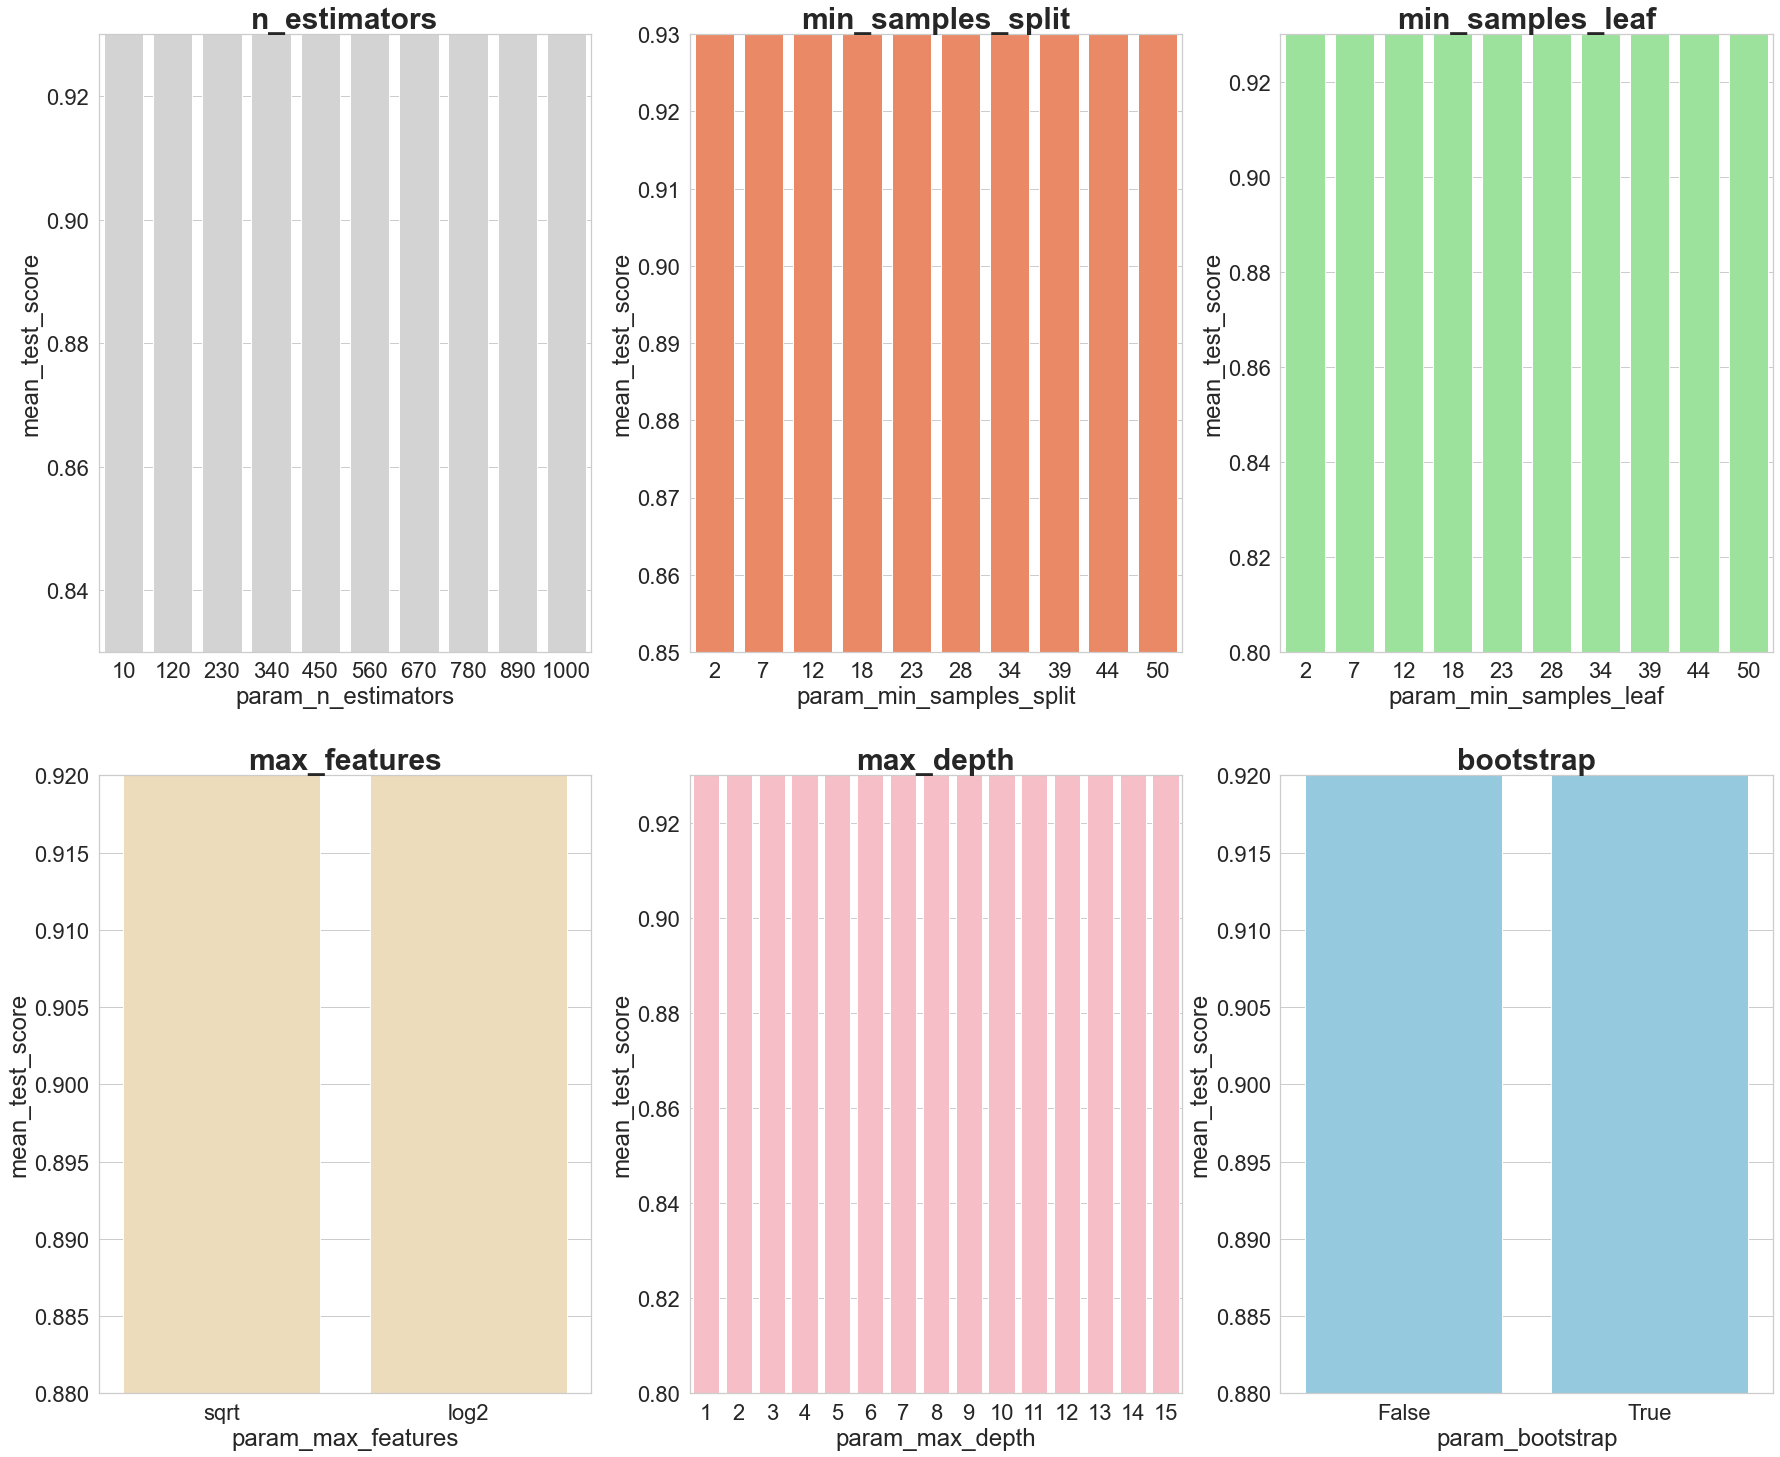

In [183]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.83,.93])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.85,.93])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.80,.93])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.88,.92])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.80,.93])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap', y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.88,.92])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

Если проанализировать вышеприведённые графики, то можно нельзя заметить некоторые интересные вещи, говорящие о том, как, в среднем, каждое значение гиперпараметра влияет на модель.

In [184]:
clf_rf.score(X, y) 

0.9817270375161707

In [185]:
rs.score(X, y) 

0.9904592496765847

In [187]:
# Сохраним предсказанные значенияс помощью модели clf_rf 
y_pred_clf_rf = clf_rf.predict(X) 

In [188]:
# Сохраним предсказанные значенияс помощью модели rs 
y_pred_rs = rs.predict(X) 

In [189]:
from sklearn.metrics import roc_auc_score 

try:
    roc_auc_score(y, y_pred_clf_rf)
except ValueError:
    pass